In [1]:
import re
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data_dir = 'data/aclImdb'
data = {}
for split in ["train", "test"]:
    data[split] = []
    for sentiment in ["neg", "pos"]:
        score = 1 if sentiment == "pos" else 0
        path = os.path.join(data_dir, split, sentiment)
        file_names = os.listdir(path)
        for f_name in file_names:
            with open(os.path.join(path, f_name), "r", encoding="utf-8") as f:
                review = f.read()
                data[split].append([review, score])

# Shuffle the training data
np.random.seed(42)
np.random.shuffle(data["train"])
data["train"] = pd.DataFrame(data["train"], columns=["text", "sentiment"])

# Shuffle the test data
np.random.seed(42)
np.random.shuffle(data["test"])
data["test"] = pd.DataFrame(data["test"], columns=["text", "sentiment"])

In [3]:
data["train"].head()

,text,sentiment
0,This movie is another Christian propaganda fil...,0
1,A woman who hates cats (Alice Krige) and her s...,1
2,"Beast Wars is a show that is over-hyped, overp...",0
3,"An excellent example of ""cowboy noir"", as it's...",1
4,"Ok, basically this is a popcorn sci-fi movie, ...",1


In [4]:
data["test"].head()

,text,sentiment
0,"Now, I loved ""Lethal Weapon"" and ""Kiss Kiss Ba...",0
1,"First of all, I should point out that I really...",1
2,It's been said that some directors make small ...,0
3,"""The Seven-Ups"" seems like a replay of ""The Fr...",1
4,This timeless summer love story is a classic a...,1


In [5]:
train_data = data["train"]
test_data = data["test"]
train_data.head()

,text,sentiment
0,This movie is another Christian propaganda fil...,0
1,A woman who hates cats (Alice Krige) and her s...,1
2,"Beast Wars is a show that is over-hyped, overp...",0
3,"An excellent example of ""cowboy noir"", as it's...",1
4,"Ok, basically this is a popcorn sci-fi movie, ...",1


In [6]:
train_data.shape

(25000, 2)

In [7]:
test_data.shape

(25000, 2)

In [8]:
# Test clean text
def clean_text(text):
    # remove html tags
    text = re.sub(r'<.*?>', '', text)
    #print('html tags removed: ', text)
    # remove [\], ['] and ["]
    text = re.sub(r'[\[\]\'\"]', '', text)
    #print('[\], [], [\'] removed: ', text)
    text = text.strip().lower()
    # thay dấu chấm bằng dấu cách
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text


clean_text("<html>This is not '\ [] \" a sentence.<\html>").split()

['this', 'is', 'not', 'a', 'sentence']

Biểu diễn bình luận dưới dạng vector

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Exammple for testing
training_texts = [
    "This is a good cat cat",
    "This is a bad day"
]

test_texts = [
    "This day is a good day"
]

In [10]:
# Create the vectorizer
# stop_words: là những từ mà được build sẵn trong thư viện sklearn bao gồm những từ không có ý nghĩa như: is, a, an, the...
vectorizer = CountVectorizer(stop_words="english", preprocessor=clean_text)
vectorizer.fit(training_texts)
vectorizer

CountVectorizer(preprocessor=<function clean_text at 0x7fcd566e2170>,
                stop_words='english')

In [11]:
vectorizer.vocabulary_

{'good': 3, 'cat': 1, 'bad': 0, 'day': 2}

In [12]:
vectorizer = CountVectorizer(stop_words="english", preprocessor=clean_text)
test_train_feature = vectorizer.fit_transform(training_texts)
vectorizer.vocabulary_

{'good': 3, 'cat': 1, 'bad': 0, 'day': 2}

In [13]:
type(test_train_feature)

scipy.sparse.csr.csr_matrix

In [14]:
test_train_feature.todense()

matrix([[0, 2, 0, 1],
        [1, 0, 1, 0]])

In [15]:
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
inv_vocab

{3: 'good', 1: 'cat', 0: 'bad', 2: 'day'}

In [16]:
vocabulary = [inv_vocab[i] for i in range(len(inv_vocab))]
vocabulary

['bad', 'cat', 'day', 'good']

In [17]:
list(vectorizer.vocabulary_.keys())

['good', 'cat', 'bad', 'day']

### Tạo CountVectorizer
Vectorier được dùng để vectơ hóa các bình luận.

In [18]:
vectorizer = CountVectorizer(stop_words="english", preprocessor=clean_text)

### Biến đổi bình luận thành vectơ

In [19]:
train_data.head()

,text,sentiment
0,This movie is another Christian propaganda fil...,0
1,A woman who hates cats (Alice Krige) and her s...,1
2,"Beast Wars is a show that is over-hyped, overp...",0
3,"An excellent example of ""cowboy noir"", as it's...",1
4,"Ok, basically this is a popcorn sci-fi movie, ...",1


In [20]:
test_data.head()

,text,sentiment
0,"Now, I loved ""Lethal Weapon"" and ""Kiss Kiss Ba...",0
1,"First of all, I should point out that I really...",1
2,It's been said that some directors make small ...,0
3,"""The Seven-Ups"" seems like a replay of ""The Fr...",1
4,This timeless summer love story is a classic a...,1


In [21]:
test_data.shape

(25000, 2)

In [22]:
training_features = vectorizer.fit_transform(train_data["text"])
test_features = vectorizer.transform(test_data["text"])

In [23]:
training_features.shape

(25000, 80000)

### Tạo và huấn luyện mô hình

In [24]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(training_features, train_data["sentiment"])

/Users/ngothai/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

### Đánh giá mô hình

In [25]:
from sklearn.metrics import accuracy_score

y_test_pred = model.predict(test_features)

In [26]:
acc = accuracy_score(test_data["sentiment"], y_test_pred)
print("Accuracy on the IMDB dataset: {:.2f}%".format(acc*100))

Accuracy on the IMDB dataset: 83.69%


### (Tùy chọn) Đánh giá mô hình sử dụng f1 score

In [27]:
from sklearn.metrics import f1_score
f1 = f1_score(test_data["sentiment"], y_test_pred, average="macro")
print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.84


### Cải thiện mô hình

Dùng [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) với [n-gram](https://en.wikipedia.org/wiki/N-gram)

In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), preprocessor=clean_text, stop_words="english") # n-gram (1,2) là 1-gram và 2-gram (1,2)
training_features = vectorizer.fit_transform(train_data["text"])
test_features = vectorizer.transform(test_data["text"])

model = LinearSVC()
model.fit(training_features, train_data["sentiment"])

y_test_pred = model.predict(test_features)
acc = accuracy_score(test_data["sentiment"], y_test_pred)
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))

Accuracy on the IMDB dataset: 88.65


In [29]:
from sklearn.metrics import f1_score
f1 = f1_score(test_data["sentiment"], y_test_pred, average="macro")
print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.89


## Phân loại hình ảnh chó mèo

In [30]:
%conda install opencv

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [31]:
import cv2

In [32]:
def get_dog_cat_data(folder, image_size):
    """
    Loads the data from the folder and returns the images and the labels
    """
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # resize image to (image_size, image_size)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            if "dog" in filename:
                labels.append(1)
            else:
                labels.append(0)
    return np.array(images), np.array(labels)

In [33]:
images, labels = get_dog_cat_data("data/dogs-vs-cats/train", 28)

In [34]:
images.shape

(25000, 28, 28, 3)

In [35]:
labels.shape

(25000,)

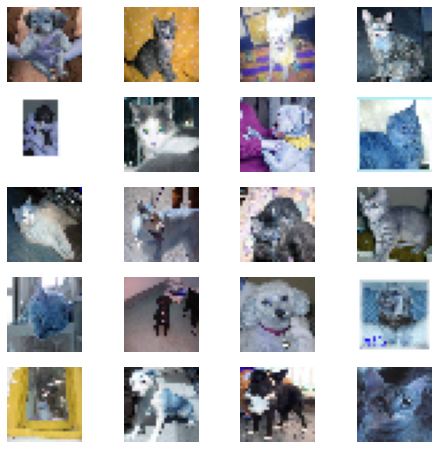

In [36]:
w=10
h=10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Tiền xử lý hình ảnh

In [37]:
images = images.reshape(-1, 28*28*3)
print(images.shape)

(25000, 2352)


In [38]:
# Chia tỷ lệ mọi giá trị điểm ảnh giữa 0 và 1
images = images / 255.0

### Chia tách tập dữ liệu
Hãy chia tập dữ liệu thành train/test với tỷ lệ 9:1. Chạy cell dưới đây để chia tập dữ liệu.

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [40]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22500, 2352)
(2500, 2352)
(22500,)
(2500,)


### Tạo và huấn luyện mô hình
Hãy tạo và huấn luyện mô hình sử dụng **scikit-learn**. Bạn không cần lo lắng quá nhiều về chi tiết của mô hình lúc này, chúng ta sẽ nghiên cứu nó kỹ hơn trong khóa sau. Hãy chạy cell dưới đây để tạo và huấn luyện mô hình **MLPClassifier()** với các tham số:

  * solver='adam'
  * alpha=1e-5
  * activation='relu'
  * hidden_layer_sizes=(64, 64)
  * random_state=1

Để biết thêm chi tiết về các tham số của MLPClassifier, hãy xem [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [41]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='adam', alpha=1e-5, activation='relu', hidden_layer_sizes=(64, 64), random_state=1)

nn_model.fit(X_train, y_train)

/Users/ngothai/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64, 64), random_state=1)

### Đánh giá mô hình
Chúng ta sẽ sử dụng hàm **score** của lớp [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) để đánh giá độ chính xác của **X_train** và **X_test**.

In [42]:
train_accuracy = nn_model.score(X_train, y_train)
test_accuracy = nn_model.score(X_test, y_test)
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))

Train accuracy: 0.85
Test accuracy: 0.61


### (Tùy chọn) Đánh giá mô hình sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng.

In [43]:
from sklearn.metrics import f1_score

y_test_pred = nn_model.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print("F1 score: {:.2f}".format(f1))

F1 score: 0.59


In [44]:
from sklearn.metrics import accuracy_score

y_test_pred = model.predict(test_features)

In [45]:
acc = accuracy_score(test_data["sentiment"], y_test_pred)
print("Accuracy on the IMDB dataset: {:.2f}%".format(acc*100))

Accuracy on the IMDB dataset: 88.65%


### (Tùy chọn) Đánh giá mô hình sử dụng f1 score

In [46]:
from sklearn.metrics import f1_score
f1 = f1_score(test_data["sentiment"], y_test_pred, average="macro")
print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.89


### Cải thiện mô hình

Dùng [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) với [n-gram](https://en.wikipedia.org/wiki/N-gram)

In [47]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), preprocessor=clean_text, stop_words="english") # n-gram (1,2) là 1-gram và 2-gram (1,2)
training_features = vectorizer.fit_transform(train_data["text"])
test_features = vectorizer.transform(test_data["text"])

model = LinearSVC()
model.fit(training_features, train_data["sentiment"])

y_test_pred = model.predict(test_features)
acc = accuracy_score(test_data["sentiment"], y_test_pred)
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))

Accuracy on the IMDB dataset: 88.65


In [48]:
from sklearn.metrics import f1_score
f1 = f1_score(test_data["sentiment"], y_test_pred, average="macro")
print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.89


## Phân loại hình ảnh chó mèo

In [49]:
%conda install opencv

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [50]:
import cv2

In [51]:
def get_dog_cat_data(folder, image_size):
    """
    Loads the data from the folder and returns the images and the labels
    """
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # resize image to (image_size, image_size)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            if "dog" in filename:
                labels.append(1)
            else:
                labels.append(0)
    return np.array(images), np.array(labels)

In [52]:
images, labels = get_dog_cat_data("data/dogs-vs-cats/train", 28)

In [53]:
images.shape

(25000, 28, 28, 3)

In [54]:
labels.shape

(25000,)

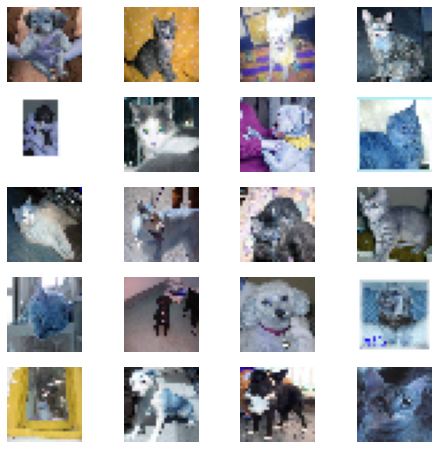

In [55]:
w=10
h=10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Tiền xử lý hình ảnh

In [56]:
images = images.reshape(-1, 28*28*3)
print(images.shape)

(25000, 2352)


In [57]:
# Chia tỷ lệ mọi giá trị điểm ảnh giữa 0 và 1
images = images / 255.0

### Chia tách tập dữ liệu
Hãy chia tập dữ liệu thành train/test với tỷ lệ 9:1. Chạy cell dưới đây để chia tập dữ liệu.

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22500, 2352)
(2500, 2352)
(22500,)
(2500,)


### Tạo và huấn luyện mô hình
Hãy tạo và huấn luyện mô hình sử dụng **scikit-learn**. Bạn không cần lo lắng quá nhiều về chi tiết của mô hình lúc này, chúng ta sẽ nghiên cứu nó kỹ hơn trong khóa sau. Hãy chạy cell dưới đây để tạo và huấn luyện mô hình **MLPClassifier()** với các tham số:

  * solver='adam'
  * alpha=1e-5
  * activation='relu'
  * hidden_layer_sizes=(64, 64)
  * random_state=1

Để biết thêm chi tiết về các tham số của MLPClassifier, hãy xem [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [60]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='adam', alpha=1e-5, activation='relu', hidden_layer_sizes=(64, 64), random_state=1)

nn_model.fit(X_train, y_train)

/Users/ngothai/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(64, 64), random_state=1)

### Đánh giá mô hình
Chúng ta sẽ sử dụng hàm **score** của lớp [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) để đánh giá độ chính xác của **X_train** và **X_test**.

In [61]:
train_accuracy = nn_model.score(X_train, y_train)
test_accuracy = nn_model.score(X_test, y_test)
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))

Train accuracy: 0.85
Test accuracy: 0.61


### (Tùy chọn) Đánh giá mô hình sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng.

In [62]:
from sklearn.metrics import f1_score

y_test_pred = nn_model.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print("F1 score: {:.2f}".format(f1))

F1 score: 0.59
